# EMP Metabolomics feature table distribution visualization

Author: Louis Felix Nothias, UC San Diego 

Date: 2021/01/28

### Objectifs:
Explore the distribution of intensities in a feature table.
 
### Steps:

- Take and prepare the feature table and merge it with the metadata
- Visualize the distribution of intensities based on selected metadata

### Code notes
The code should handle standard MZmine ion identity networking table

## Prepare the script -> run the following cells

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [143]:
#Define the feature tables
filename_before_gapfill = 'feature_table/EMPsubset_before_gapfill_quant.csv'
filename_after_gapfill = 'feature_table/EMPsubset_after_gapfill_quant.csv'
filename = 'feature_table/1907_EMPv2_INN_GNPS_quant.csv'
#Define metadata filename
metadata_filename = 'metadata/emp500_metadata_basic.txt'

In [158]:
# This function takes a feature table and metadata table. Concatenate them. Filter based on metadata and visualize.
def view_distribution(filename, metadata_filename, average=None, min_intensity=None, max_intensity=None, \
                                     min_completness=None, subset1=None, value1=None, subset2=None, value2=None, \
                                     plot_color='Blue',xmax=1E8, xmax_zoom=1E7):
    
    ft = pd.read_table(filename, index_col=None, header=0, sep=',', low_memory=False, skiprows=0)
    
    
    #Drop IIN columns
    ft = ft.drop(columns=['row m/z','row retention time','correlation group ID', 'annotation network number','best ion','auto MS2 verify','identified by n=','partners','neutral M mass'])
    # Get the correct column type
    ft = ft.infer_objects()
    ft = ft.set_index('row ID', drop=True)
    # Tranpose the table
    ft_T = ft.T
    ft_T['duplicate_check'] = ft_T.index
    
    # Removing metabolomics sample duplicate filenames (these are not critical samples, mostly technical samples)
    ft2 = ft_T
    ft2 = ft2[~ft2.duplicate_check.str.contains("Unnamed: 815")]
    ft2 = ft2[~ft2.duplicate_check.str.contains("Peak area.")]
    ft2["duplicate_check"] = ft2["duplicate_check"].str.rstrip(" croppped Peak area")
    #ft2 = ft2.drop(columns=['duplicate_check'])
    ft2 = ft2.set_index('duplicate_check', drop=True)
    ft2["lcms_sample_name_fbmn"] = ft2.index
    
    md = pd.read_table(metadata_filename, index_col=None, header=0, sep='\t')\

    md['lcms_sample_name_fbmn']=md.lcms_sample_name_fbmn.astype('str')
    md_filtered = md[~md.lcms_sample_name_fbmn.str.contains("not applicable")]
    md_filtered = md_filtered.infer_objects()
    
    #Change the column type for batch only interrogate (some potentially usefull samples don't have a batch)
    if subset2 == "lcms_batch":
        md_filtered = md_filtered[~md_filtered.lcms_batch.str.contains("not applicable")]
        md_filtered["lcms_batch"] = md_filtered["lcms_batch"].astype(float).astype(int)
    else:
        pass

    df = pd.merge(md_filtered,ft2, on=['lcms_sample_name_fbmn'], how='right')
    df.head(2)
    
    # Filter the table based on subset/value
    try: 
        df = df[df[subset1] == value1]
    except:
        pass
    try: 
        df = df[df[subset2] == value2]
    except:
        pass
    
    try: 
        for x in df.columns:
            if x in md.columns:
                df = df.drop(columns=[x])
    except:
        pass

    print(df.shape)
    
    # drop columns based on completeness
    try:
        df[df<min_intensity]=np.nan
    except:
        pass
    
    # drop columns based on completeness
    try:
        df = df.dropna(thresh=df.shape[0]*min_completness,how='all',axis=1)
    except:
        pass
    
    # Make a long list for visualization
    big_liste = []
    
    if average == 'MEDIAN':
        print('Computing the MEDIAN for a feature')
        for x in df.columns:
            try:
                value = df[x].median()
                if min_intensity <= value <=  max_intensity:
                    big_liste.append(value)
            except:
                continue
                
    if average == 'MEAN':
        print('Computing the MEAN for a feature')
        for x in df.columns:
            try:
                value = df[x].mean()
                if min_intensity <= value <=  max_intensity:
                    big_liste.append(value)
            except:
                raise    
                
    elif average == 'RAW':
        print('No transform, raw values will be used')
        for x in df.columns:
            try:
                liste = df[x].to_list()
                liste = [x for x in liste if x <= max_intensity]
                liste = [x for x in liste if x >= min_intensity]
                big_liste = big_liste + liste
            except:
                raise
                
    # Visualize
    fig1, ax1 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax1 = sns.violinplot(x=big_liste,color=plot_color)
    ax1.set(xlabel="Feature intensity")
    plt.title("Distribution plot for metabolomics feature "+str(average)+" intensity (below "+str(max_intensity)+")\n for subset "+str(subset1)+"/"+str(value1)+" and "+str(subset2)+"/"+str(value2)+"\n Samples="+str(df.shape[0])+" Features="+str(df.shape[1]), size=12)
    ax1.set(xlim=(0,xmax))
    plt.show() 
    plt.close()

    fig2, ax2 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax2 = sns.distplot(big_liste, kde = None, bins = 10000, color=plot_color)
    ax2.set(xlabel="Feature intensity")
    ax2.set(ylabel="Count")
    ax2.set(xlim=(0, xmax))
    plt.show()
    plt.close()
    
    fig1, ax3 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax3 = sns.violinplot(x=big_liste,color=plot_color)
    ax3.set(xlim=(0, xmax_zoom))
    ax3.set(xlabel="Feature intensity")
    plt.show() 
    plt.close()

## Metadata examination -> run the following cell to see metadata columns

In [145]:
# Just run the cell
md = pd.read_table(metadata_filename, index_col=None, header=0, sep='\t')

print('This are the metadata columns')
print(list(md.columns))

This are the metadata columns
['sample_name', 'sample_name_original', 'barcode_prefix', 'sample_type', 'gcms_sample_name', 'gcms_sequence', 'gcms_analysis_batch', 'gcms_run_location', 'lcms_sample_name_fbmn', 'lcms_sample_name_cmn', 'lcms_batch', 'lcms_extraction_protocol', 'lcms_sample_type', 'lcms_sample_type_sub', 'lcms_sampling_material', 'collection_timestamp', 'depth_sample', 'depth_method', 'description', 'elevation', 'emp500_principal_investigator', 'emp500_study_id', 'emp500_title', 'empo_0', 'empo_1', 'empo_2', 'empo_3', 'env_biome', 'env_feature', 'env_material', 'env_package', 'environmental_package', 'geo_loc_name', 'host_subject_id', 'iron_mg_per_l', 'latitude', 'longitude', 'project_name', 'scientific_name', 'read_count_shotgun_r1', 'read_count_shotgun_woltka_uniq', 'read_count_shotgun_rep200', 'alpha_shotgun_woltka_min3450_richness', 'alpha_shotgun_woltka_min3450_shannon', 'alpha_shotgun_woltka_min3450_faithspd', 'alpha_shotgun_woltka_rar3450_richness', 'alpha_shotgun_w

## Check the metadata values -> specify the subsets to be used for filtering

In [146]:
#Specify the subsets
try: 
    liste = [ 'lcms_batch', 'lcms_extraction_protocol', 'lcms_sample_type',
       'lcms_sample_type_sub','lcms_sampling_material']
    for x in liste:
        print(str(x))
        print(set(md[x]))
except:
    pass

lcms_batch
{nan, '3', '6', '5', '1', '8', 'not applicable', '9', '2', '4', '7'}
lcms_extraction_protocol
{nan, 'Filter_201901_UCSD', 'Swabs_201901_UCSD', 'Bulk_Seed_PNNL', 'Bulk_201901_UCSD', 'not applicable'}
lcms_sample_type
{nan, 'Sample', 'Background_control', 'QC', 'Material_control', 'not applicable'}
lcms_sample_type_sub
{nan, 'Qcmix', 'Bulk', 'Material_control', 'not applicable', 'SPE', 'Filter', 'Solvent', 'QC6mix', 'Swabs'}
lcms_sampling_material
{nan, 'Sterivex', 'Nasco_WhirlPak', 'WaterFilter_GPWP', 'CTAB2x', 'CTAB', 'Ziplock', 'not applicable', 'Powerbeads'}


## View in background controls samples (SPE)

(25, 57339)
Computing the MEDIAN for a feature


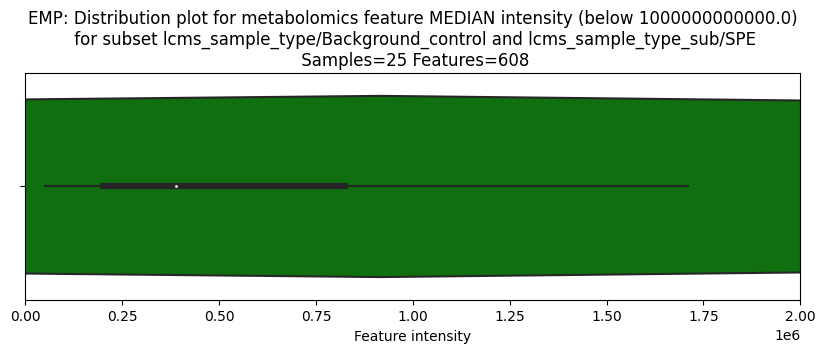

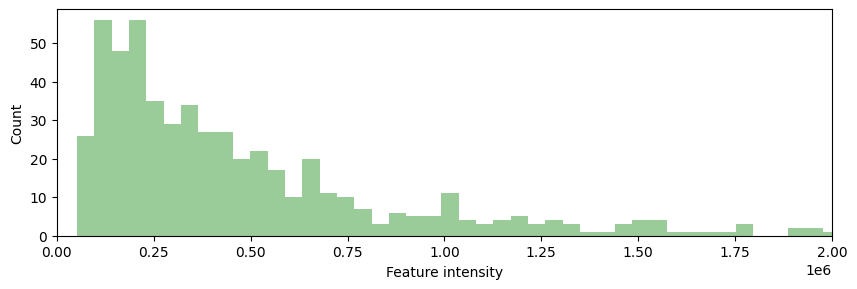

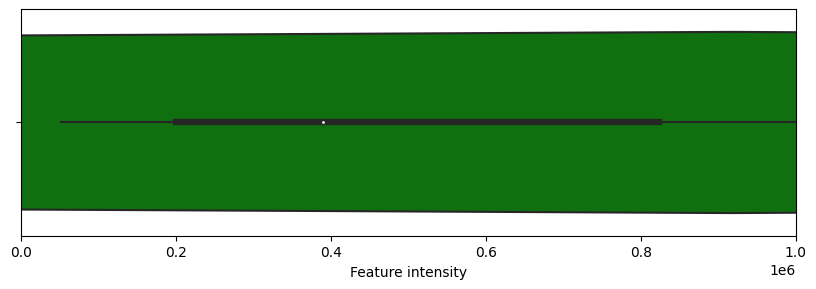

In [159]:
view_distribution(filename, metadata_filename,
                             average ='MEDIAN', min_intensity=3E4, max_intensity=1E12, min_completness = 0.95, \
                             subset1="lcms_sample_type", value1="Background_control", \
                             subset2="lcms_sample_type_sub", value2="SPE", plot_color="green", xmax=2E6, xmax_zoom = 1E6)

## View in background controls samples (Swabs)

(13, 57339)
Computing the MEDIAN for a feature


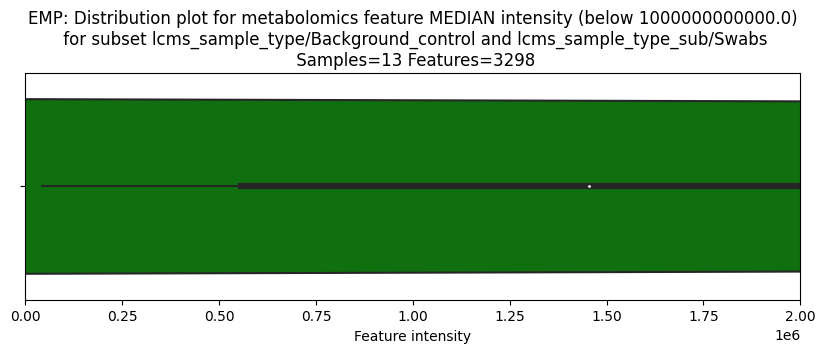

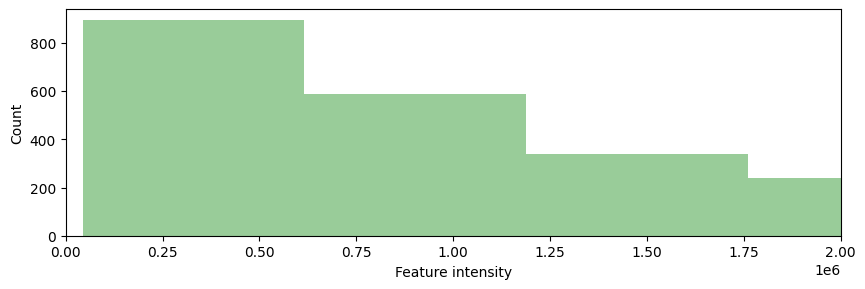

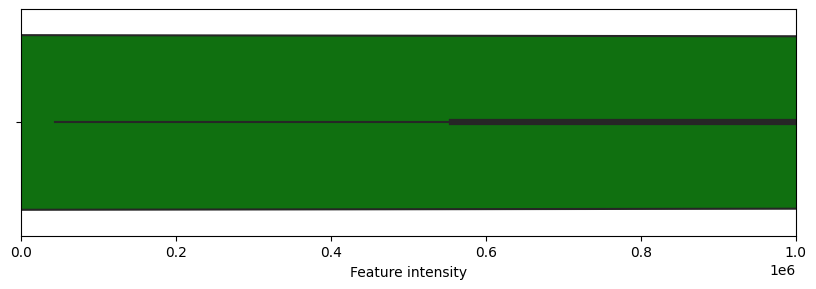

In [160]:
view_distribution(filename, metadata_filename,
                             average ='MEDIAN', min_intensity=3E4, max_intensity=1E12, min_completness = 0.95, \
                             subset1="lcms_sample_type", value1="Background_control", \
                             subset2="lcms_sample_type_sub", value2="Swabs", plot_color="green", xmax=2E6, xmax_zoom = 1E6)

## Looking at one sampling material

(5, 57339)
No transform, raw values will be used


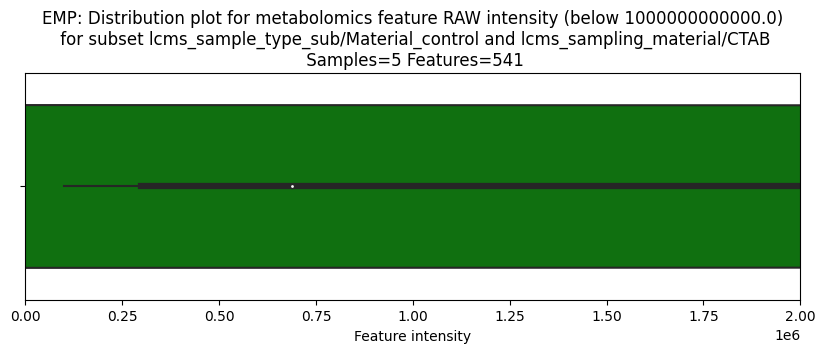

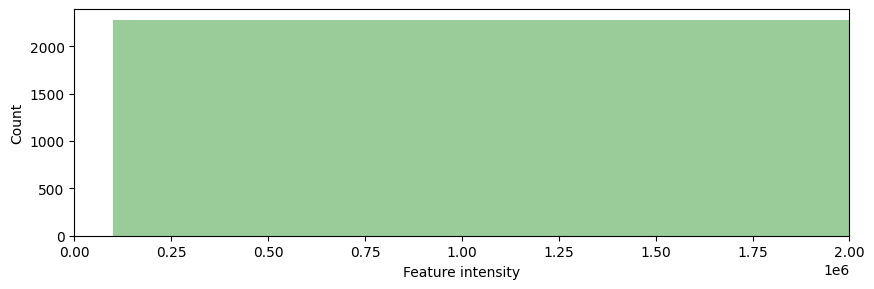

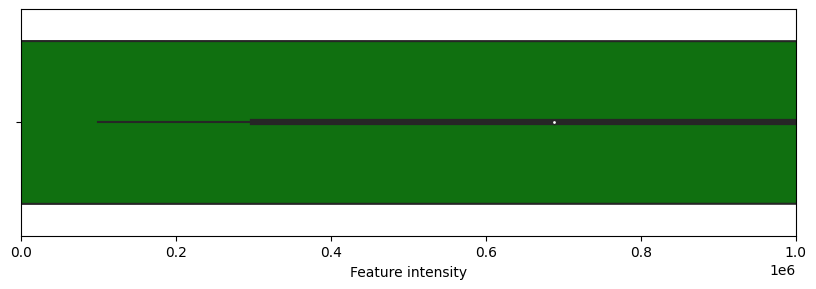

In [162]:
view_distribution(filename, metadata_filename,
                             average ='RAW', min_intensity=1E5, max_intensity=1E12, min_completness = 1, \
                             subset1="lcms_sample_type_sub", value1="Material_control", \
                             subset2="lcms_sampling_material", value2="CTAB", plot_color="green", xmax=2E6, xmax_zoom = 1E6)

### Interpretation
-> Exluding the lowest intensities (issued from the gap filling) with a treshold of approximatively 3E4. 

-> By using a minimum completeness of approx 90%, it seems that using a treshold of 1E5 is doing a pretty job at removing the features from these background/sample groups